# Project - Seattle Airbnb Open Data

---

---

# Introduction

Whenever someone visits plans to visit a new city, finding an accommodation is one of the first tasks that takes place.
Usually, we want to find a comfortable place with an affordable price. 
But how can we know if it's too expensive due to the location, amenities or time of the year?

Fortunately, with publicly accesible AirBnb data available on Kaggle, we can analyse these aspects and make an informed decision on a reservation.

# 1 - Business Understanding

## Questions
* What are the busiest times of the year to visit Seattle?
* By how much do prices spike?
* Can we see which neighboorhods are most desired in this time of the year?
* What characteristics affects the price of a listing?
* Can we predict a rental price?
---
---

# 2 - Data Understanding


Most of ours questions are about prices. What does determine pricing?
According to https://www.airbnb.com/help/article/125/how-is-the-price-determined-for-my-reservation?locale=en

- Costs determined by the host:
    - Nightly price: Nightly rate decided by the host;
    - Cleaning fee: One-time fee charged by some hosts to cover the cost of cleaning their space;
    - Extra guest fees: One-time fee charged by some hosts to cover other costs related to using their space;
- Costs determined by Airbnb: Airbnb service fee;
- Other costs that may be included: currency exchange fees, VAT, other local taxes etc.

In our analysis we will concentrate on the factors, which influence the nightly price, determined by the host. 

Actually, AirBnB already has an algorithm, which suggests hosts the price. 
The approach for the algorithm and challenges are described in the article here (https://www.vrmintel.com/inside-airbnbs-algorithm/). 

From the article we have factors that affect the nightly price:

- Time of the year, when reservation is made;
- Amenities offered (like Wi-Fi and TV);
- Neighbourhood
    * It is better to use neighbourhood information rather then exact coordinates to describe the listing location, because sometimes even close locations might have huge difference in listing prices, if they belong to different neighbourhoods or are located different sides of the river.

## The first look at the data:
- what information we have?
- what information is missing?
- discover general facts: time period, total number of listings in the dataset;

In [298]:
# Importing Libraries

# Import linear algebra and data manipulation
import numpy as np
import pandas as pd
import scipy as sp

# Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

AirBnB provided us with 3 datasets for Seattle:

1. listings.csv - summary information on listing in Seattle such as: location, host information, cleaning and guest fees, amenities etc.
2. calendar.csv - calendar data for the listings: availability dates, price for each date.
3. reviews.csv - summary review data for the listings.

### Reading Datasets
#### Listings

In [299]:
# Reading Datasets
listings_df = pd.read_csv('Seattle_AirBnB/listings.csv')
listings_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


Statistics for listings.csv dataset:
- Number of listings

In [300]:
listings_number = listings_df['id'].count()
listings_number

3818

- Number of unique hosts

In [301]:
hosts_number = len(listings_df['host_id'].unique())
hosts_number

2751

Dataset missing values statistics (only columns with any missing data are represented on the diagram):

In [302]:
def select_columns_missing_values(data):
    """
    Filter out only columns, which have missing values
    
    Inputs: data = pd.DataFrame()
    
    Outputs: new_df = pd.DataFrame()
    """
    new_df = pd.DataFrame(data[data > 0].sort_values(ascending=False), columns=['Value'])
    return new_df
    

In [303]:
def plot_missing_values(data, name_png, width, height):
    """
    Plot a chart showing the columns missing values and its %.
    
    Inputs: data = pd.DataFrame()
            name_png = name of the picture that will be generated
            width = width of the figure
            height = height of the figure
    """
    #find percentage of missing values for each column
    data_missing_df = data.isnull().mean()

    #filter out only columns, which have missing values
    data_columns_missing_values = select_columns_missing_values(data_missing_df)

    #plot the results
    sns.set_theme(style="whitegrid")

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(width, height))
    sns.set_color_codes("pastel")
    missing_values = sns.barplot(x=data_columns_missing_values.Value, 
                                y=data_columns_missing_values.index, 
                                data=data_columns_missing_values, 
                                color="b")
    
    # from https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn
    for p in ax.patches:
        width = p.get_width()    # get bar length
        ax.text(width,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:1.5f}'.format(width), # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment

    missing_values.axes.set_title("Missing values per column", fontsize=22) 
    missing_values.set_xlabel("Missing values/Total", fontsize=16)


    plt.savefig(name_png)
    plt.show()

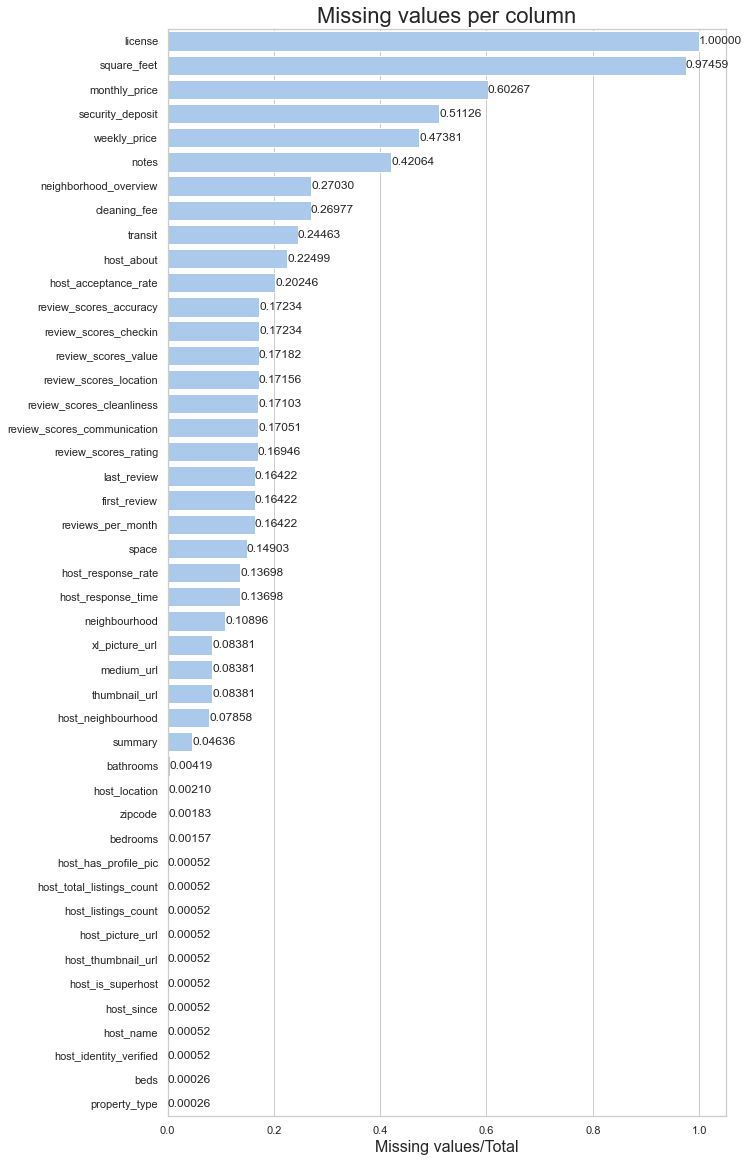

In [304]:
plot_missing_values(listings_df, 'missing_values_per_column_listings_df.png', 10, 20)

   As we can see in the chart above, and more detailed in the table below, in the columns 'license', 'square_feet', 'monthly_price', 'security_deposit', 'weekly_price' and 'notes' we have more than 40% of missing values.

   For now we are not going to use the data of these columns in our analysis, because it will obviously lead to overfitting our machine learning model.

In [305]:
# Save the columns names in .csv to analyse later
pd.DataFrame(listings_df.columns).to_csv('listings_df_columns.csv')

#### Calendar

In [306]:
calendar_df = pd.read_csv('Seattle_AirBnB/calendar.csv')
calendar_df.head(3)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN


Dataset missing values statistics (only columns with any missing data are represented on the diagram):

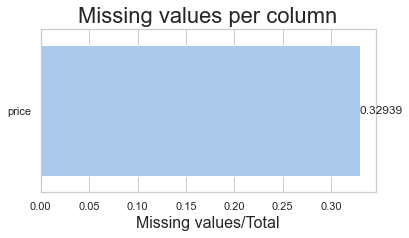

In [307]:
plot_missing_values(calendar_df, 'missing_values_per_column_calendar_df.png', 6, 3)

As we can see in the chart, the price columns is missing only 32% values

---
#### Reviews

In [308]:
reviews_df = pd.read_csv('Seattle_AirBnB/reviews.csv')
reviews_df.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."


We are not going to be using this for now

---
---

# 3 - Data Preparation

Before trying to get the first outcomes, the data should be pre-processed:
- Format values to easier plot and wrangling data. Ex: dates and prices should be converted from text into numbers.
- Irrelevant columns and rows, which contain missing data should be removed from the analysis;
- Datasets should be merged into one using the listing identifier. Dataset `calendar_df` contains prices and `listings_df` contains features that can affect price.

In [309]:
# Helper functions for extracting date
def get_month_from_date(row):
    ''' Get month from date represented as a string '''
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    ''' Get year from date represented as a string '''
    return int(row['date'].split('-')[0])

### `calendar_df`

In [310]:
# Changing column available to boolean calendar_df.
mapping_available ={'t': True, 'f': False}
calendar_df['available'] = calendar_df['available'].map(mapping_available)

# Convert date from the calendar into month
#TODO: change extraction of month and year to a better method
calendar_df['month'] = calendar_df.apply(lambda row : get_month_from_date(row), axis=1)
calendar_df['year'] = calendar_df.apply(lambda row : get_year_from_date(row), axis=1)

# Convert price to number and drop the price_x column
calendar_df.rename(columns={'price':'price_x'}, inplace=True)
calendar_df['price'] = calendar_df['price_x'].astype(str)
calendar_df['price'] = calendar_df['price'].str.replace("$", "").str.replace(",", "").str.replace(" ", "").astype("float")
calendar_df.drop(columns=['price_x'], inplace=True)

<ipython-input-310-6cb19c43ad2d>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  calendar_df['price'] = calendar_df['price'].str.replace("$", "").str.replace(",", "").str.replace(" ", "").astype("float")


In [311]:
calendar_df.head(100)

,listing_id,date,available,month,year,price
0,241032,2016-01-04,True,1,2016,85.0
1,241032,2016-01-05,True,1,2016,85.0
2,241032,2016-01-06,False,1,2016,NaN
3,241032,2016-01-07,False,1,2016,NaN
4,241032,2016-01-08,False,1,2016,NaN
...,...,...,...,...,...,...
95,241032,2016-04-08,True,4,2016,85.0
96,241032,2016-04-09,True,4,2016,85.0
97,241032,2016-04-10,True,4,2016,85.0
98,241032,2016-04-11,True,4,2016,85.0


## High level analysis

In [312]:
calendar_df.describe()

,listing_id,month,year,price
count,1.393570e+06,1.393570e+06,1.393570e+06,934542.000000
mean,5.550111e+06,6.528767e+00,2.016005e+03,137.944859
std,2.962274e+06,3.443855e+00,7.382027e-02,105.062870
min,3.335000e+03,1.000000e+00,2.016000e+03,10.000000
25%,3.258213e+06,4.000000e+00,2.016000e+03,75.000000
50%,6.118244e+06,7.000000e+00,2.016000e+03,109.000000
75%,8.035212e+06,1.000000e+01,2.016000e+03,160.000000
max,1.034016e+07,1.200000e+01,2.017000e+03,1650.000000


In [313]:
print(f"""
The average price of a listing is S{round(calendar_df['price'].mean(),2)}
The minimum price of a listing is ${round(calendar_df['price'].min(),2)}.
The maximum price of a listing is ${round(calendar_df['price'].max(),2)}.
The average price of a listing is ${round(calendar_df['price'].mean(),2)}.
Only 10% of the listings's prices are equal or under ${round(calendar_df['price'].quantile(0.10),2)}.
80% of the listings's prices are equal or under ${round(calendar_df['price'].quantile(0.80),2)}.
95% of the listings's prices are equal or under ${round(calendar_df['price'].quantile(0.95),2)}.
""")


The average price of a listing is S137.94
The minimum price of a listing is $10.0.
The maximum price of a listing is $1650.0.
The average price of a listing is $137.94.
Only 10% of the listings's prices are equal or under $55.0.
80% of the listings's prices are equal or under $181.0.
95% of the listings's prices are equal or under $333.0.



**Price Distribution**

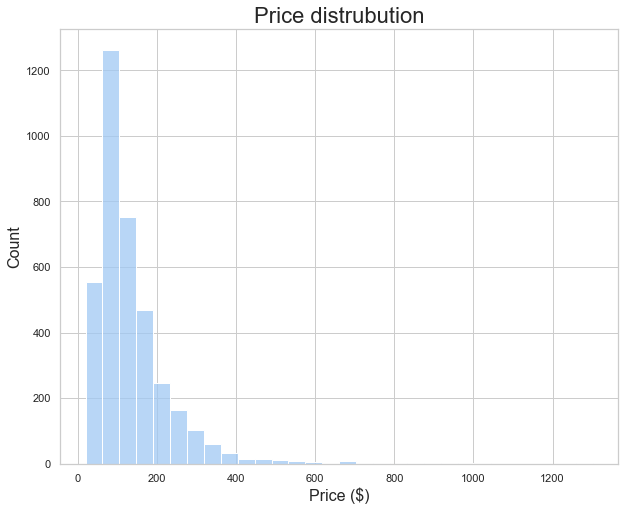

In [314]:
#get the average price for each listing
mean_price_for_listing = calendar_df.groupby('listing_id').mean()['price']

# plot results
f, ax = plt.subplots(figsize=(10, 8))
sns.set_color_codes("pastel")

hist = sns.histplot(data=mean_price_for_listing, 
            color="b", bins=30)
    
hist.axes.set_title("Price distrubution", fontsize=22) 
hist.set_xlabel("Price ($)", fontsize=16)
hist.set_ylabel("Count", fontsize=16)

plt.savefig('Price distrubution.png')
plt.show()

## 4 - Exploratory Analysis

**What Are the Busiest Times of the Year to Visit Seattle?**

- Most busiest times will have less listings? or less listings available?

So, I have decided to find how many listings there are per month and then find the percentage of listings available considering the total of listings each month

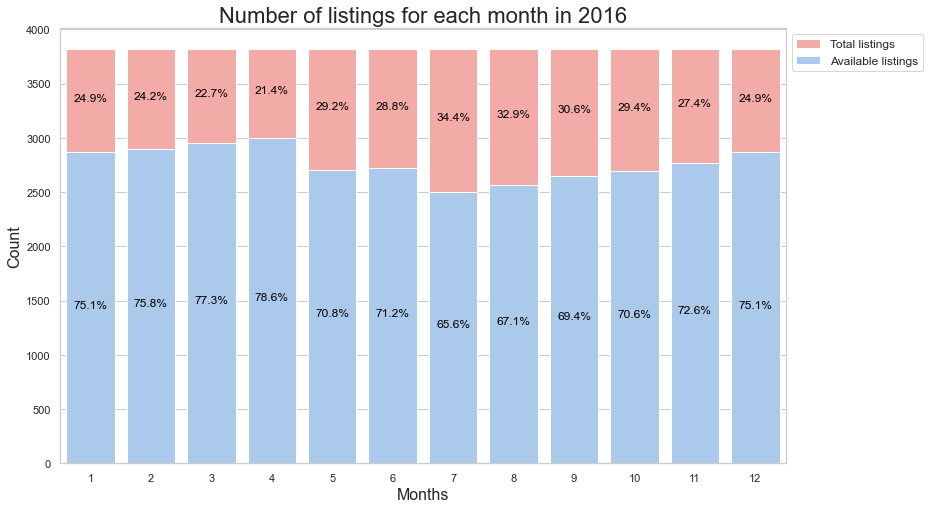

In [315]:
#find number of total number of unique listings, and unique lsittings available for each month in 2016
listings_by_month = []
listings_available_by_month = []

for i in range(1,13):
    listings_by_month.append(len(calendar_df[(calendar_df['month'] == i) & (calendar_df['year'] == 2016)]['listing_id'].unique()))
    listings_available_by_month.append(len(calendar_df[(calendar_df['month'] == i) & (calendar_df['year'] == 2016) & (calendar_df['available'] == True)]['listing_id'].unique()))

# creating dataframe from lists
listings_by_month_df = pd.DataFrame(data=listings_by_month, index=range(1,13))
listings_by_month_df.rename(columns={0:'Value'}, inplace=True)

listings_available_by_month_df = pd.DataFrame(data=listings_available_by_month, index=range(1,13))
listings_available_by_month_df.rename(columns={0:'Value'}, inplace=True)

# merging dataframes
listings_by_month_agg = pd.merge(listings_available_by_month_df, listings_by_month_df, on=listings_available_by_month_df.index)
listings_by_month_agg.drop(columns=['key_0'], inplace=True)
listings_by_month_agg.rename(columns={'Value_x' : 'Available',
                                     'Value_y': 'Total'}, inplace=True)
listings_by_month_agg.index = np.arange(1,len(listings_by_month_agg)+1)
listings_by_month_agg['Percentage'] = listings_by_month_agg['Available']/listings_by_month_agg['Total']
                                                        
# stacked bars plot
f, ax = plt.subplots(figsize=(13, 8))
sns.set_color_codes("pastel")
topbar = sns.barplot(x=listings_by_month_agg.index, 
                     y=listings_by_month_agg.Total,
                     data=listings_by_month_agg,
                     color="r",
                     label='Total listings')

# values of red bar
for index, row in listings_by_month_agg.iterrows():
    topbar.text(row.name - 1, row.Available + (row.Total - row.Available)/2, f'{round((1 - row.Available/row.Total)*100,1)}%', color='black', ha="center")

    
bottombar = sns.barplot(x=listings_by_month_agg.index, 
                        y=listings_by_month_agg.Available,
                        data=listings_by_month_agg,
                        color="b",
                        label='Available listings')

# values of blue bar
for index, row in listings_by_month_agg.iterrows():
    bottombar.text(row.name -1, row.Available/2, f'{round((row.Available/row.Total)*100,1)}%', color='black', ha="center")


# labels of the plot
bottombar.axes.set_title("Number of listings for each month in 2016", fontsize=22)
bottombar.set_xlabel("Months", fontsize=16)
bottombar.set_ylabel("Count", fontsize=16)
plt.legend(loc = 2, bbox_to_anchor = (1,1), fontsize=12)

plt.savefig('Number_of_listings_for_each_month_in_2016.png')

plt.show()
                                                        
                                                        

The number of listings in each month is constant. Therefore, the busiest time of the year to visit Seattle in 2016 will be the month with less available listings. 
The period between July, August and September (Summertime) had the lowest vacancy percentages of 2016.

**Vacancy Percentages:**

In [316]:
print(f'''
- July: {round(listings_by_month_agg.iloc[6]['Available']/listings_by_month_agg.iloc[6]['Total'],3)}
- August: {round(listings_by_month_agg.iloc[7]['Available']/listings_by_month_agg.iloc[7]['Total'],3)}
- September: {round(listings_by_month_agg.iloc[8]['Available']/listings_by_month_agg.iloc[8]['Total'],3)}
''')


- July: 0.656
- August: 0.671
- September: 0.694



In [317]:
listings_by_month_agg.sort_values(by='Percentage')

,Available,Total,Percentage
7,2503,3818,0.655579
8,2561,3818,0.670770
9,2649,3818,0.693819
10,2694,3818,0.705605
5,2705,3818,0.708486
6,2720,3818,0.712415
11,2771,3818,0.725773
12,2866,3818,0.750655
1,2868,3818,0.751179
2,2895,3818,0.758250


---

**By how much do prices spike in these months?**
 - Does the average price spike in these months?

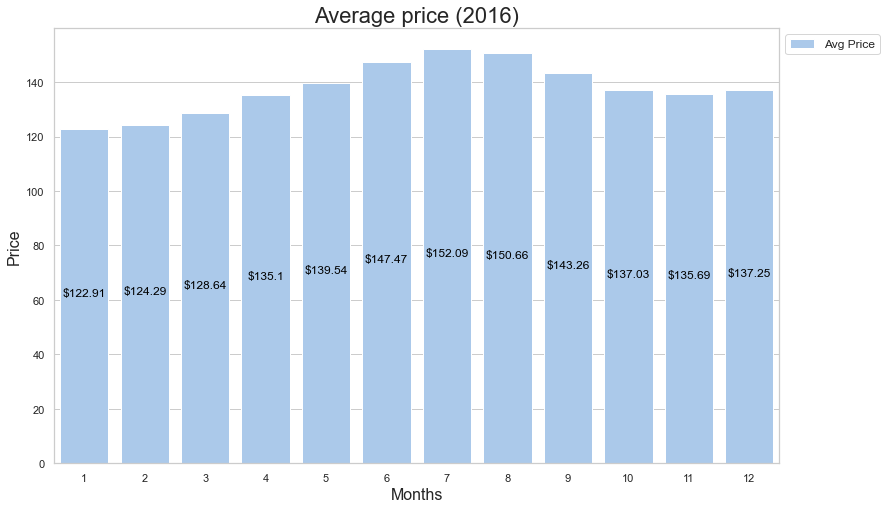

In [318]:
# Get the average price by month
average_price_by_month = pd.DataFrame(data=calendar_df.groupby(['month'])['price'].mean(), index=range(1,13))
average_price_by_month.index.rename('month', inplace=True)

# plot
f, ax = plt.subplots(figsize=(13, 8))
sns.set_color_codes("pastel")
avg_price_plot = sns.barplot(x=average_price_by_month.index, 
                        y=average_price_by_month.price,
                        data=average_price_by_month,
                        color="b",
                        label='Avg Price')

# values of blue bar
for index, row in average_price_by_month.iterrows():
    avg_price_plot.text(row.name -1, row.price/2, f'${round(row.price,2)}', color='black', ha="center")

# labels
avg_price_plot.axes.set_title("Average price (2016)", fontsize=22)
avg_price_plot.set_xlabel("Months", fontsize=16)
avg_price_plot.set_ylabel("Price", fontsize=16)
plt.legend(loc = 2, bbox_to_anchor = (1,1), fontsize=12)

plt.savefig('avg_price_2016.png')

plt.show()

In [319]:
average_price_by_month.describe()

,price
count,12.000000
mean,137.828177
std,9.517936
min,122.912176
25%,133.483876
50%,137.141887
75%,144.310246
max,152.094150


In [320]:
diff_price = average_price_by_month.max() - average_price_by_month.min()
diff_price

price    29.181974
dtype: float64

Altough the most busiest times in Seattle are between July and September, the highest average price occurs between June and August.

The highest average price occurs in July (\\$152.09) and it is \\$29.18 more expensive than the cheapest month (January, \\$122.91)

---

**Can we see which neighbourhods are most desired in this time of the year?**

For this analysis we need the column  `neighbourhood_group_cleansed` that is in the `listings_df` dataset.

Therefore, we can see this information after merging the datasets.

---

## What features influences price?

All listings have the same 'scrape_id'. It does not seems a valuable information for now.

In [321]:
# listings_df[['id', 'bedrooms', 'host_listings_count', 'host_total_listings_count']].query("host_listings_count != host_total_listings_count")
# listings_df[['id', 'bedrooms', 'host_listings_count', 'host_total_listings_count']].query("host_listings_count == host_total_listings_count")
# listings_df.shape

The columns 'host_listings_count' and 'host_total_listings_count' show the same information. we will drop the 'host_total_listings_count'.

In [322]:
listings_df[['experiences_offered']].query("experiences_offered != 'none'")

,experiences_offered


The column experiences_offered does not have missing values (as it is not present in the chart from Data Understanding topic), but all rows have the same value: 'none'.It does not seems a valuable information, so we will drop this column.

In [323]:
def date_columns_to_datetime(data, datetime_columns):
    """
    Transforms a date column with string values to datetime format.
    
    Inputs: data = pd.DataFrame
            columns = list of columns
            
    Outputs: data = pd.DataFrame
    """
    for column in datetime_columns:
        data[column] = pd.to_datetime(data[column])
    return data

def tf_columns_to_boolean(data, boolean_columns):
    """
    Transform a column that has 't' and 'f' values to 1 or 0 values.
    
    Inputs: data = pd.DataFrame
            columns = list of columns
            
    Outputs: data = pd.DataFrame
    """
    for column in boolean_columns:
        data[column].replace({'t': 1, 'f': 0}, inplace=True)
    return data
        
def description_columns_to_boolan(data, description_columns):
    """
    Transform a value to 1 if there is a description in the column, or 0 if there isn't
    
    Inputs: data = pd.DataFrame
            columns = list of columns
            
    Outputs: data = pd.DataFrame
    """
    for column in description_columns:
        # Where there is value, the value will be 1
        data[column].where(data[column].isna(), 1, inplace=True)
        
        # Where is missing value, the value will be 0
        data[column].mask(data[column].isna(), 0, inplace=True)
        
        data[column] =  data[column].astype('int')
        
    return data

def clean_string_column(data, columns):
    """
    It removes unwanted characters from rows in string columns
    
    Inputs: data = pd.DataFrame
            columns = list of columns
            
    Outputs: data_aux = pd.DataFrame
    """
    for column in columns:
        data[column] = data[column].str.lower()
        data[column] = data[column].str.replace('(', '').str.replace(')', '')
        data[column] = data[column].str.replace('{', '').str.replace('}', '')
        data[column] = data[column].str.replace('/', '_').str.replace('\\', '')
        data[column] = data[column].str.replace('-','_').str.replace(' ','_')
        data[column] = data[column].str.replace('"','').str.replace(",", "")
        data[column] = data[column].str.replace('&','and')
        data[column] = data[column].str.replace("$", "").str.replace("%", "")
        
    return data

def parse_money_columns(data, columns):
    """
    Parses a column with string containing money value to float
    
    Inputs: data = pd.DataFrame
            columns = list of columns
            
    Outputs: data_aux = pd.DataFrame
    """
    for column in columns_to_parse:
        data.rename(columns={f'{column}':f'{column}_aux'}, inplace=True)
        data[column] = data[f'{column}_aux'].astype(str)
        data[column] = data[column].astype("float")
        data.drop(columns=[f'{column}_aux'], inplace=True)
        
    return data

From Data Understanding, we can remove the columns 'license' and 'square_feet', 
since both have more than 80% of missing values

We will drop columns 'monthly_price', 'weekly_price', 'security_deposit' and 'notes'
because these have more than 40% of missing values and it might lead to overfitting our machine learning model.

We also will drop columns with irrelevant information, such as urls.
Since we are only analysing data from Seattle, columns such as city, state and country are also irrelevant
Using the assumption made above, we are not going to use exact location, instead we are going to use only 
neighbourhood_cleansed.
So we will also drop latitude and longitude columns.

For now we are not evaluating the actual text written in columns such as listing summary, space, description.
We rather can evaluate whether its presence affects in price.
Columns such as name, seems to be obligatory in form, and he have no listing missing name. Since we are not doing a NLP 
analysis of the names, this coluns has no important information for this analysis.

Also, since 'cleaning_fee' and 'extra_people' fee are define independent of the price, we are not going to use them in our analysis.

In [324]:
irrelevant_columns = ['name',
                      'license',
                      'square_feet',
                      'monthly_price', 
                      'weekly_price', 
                      'security_deposit',
                      'notes',
                      'scrape_id',
                      'listing_url',
                      'last_scraped',
                      'host_url',
                      'host_name',
                      'host_location',
                      'host_thumbnail_url', 
                      'host_picture_url',
                      'street',
                      'city', 
                      'state',
                      'zipcode',
                      'country_code', 
                      'country',
                      'market',
                      'smart_location',
                      'neighbourhood',
                      'latitude', 
                      'longitude',
                      'host_total_listings_count',
                      'experiences_offered',
                      'jurisdiction_names',
                      'calendar_updated',
                      'has_availability',
                      'guests_included',
                      'minimum_nights',
                      'maximum_nights', 
                      'availability_30', 
                      'availability_60',
                      'availability_90', 
                      'availability_365', 
                      'calendar_last_scraped',
                      'host_listings_count',
                      'calculated_host_listings_count',
                      'host_verifications',
                      'neighbourhood_cleansed',
                      'host_neighbourhood',
                      'first_review', 
                      'last_review',
                      'extra_people',
                      'cleaning_fee'
                     ]

listings_df_cleansed = listings_df.drop(columns=irrelevant_columns)

# Converting columns with date strings to datetime
datetime_columns = ['host_since']

listings_df_cleansed = date_columns_to_datetime(listings_df_cleansed, datetime_columns)

# Transform columns to booleans (1 and 0)
boolean_columns = ['host_is_superhost',
                   'host_has_profile_pic',
                   'host_identity_verified',
                   'is_location_exact',
                   'requires_license',
                   'instant_bookable',
                   'require_guest_profile_picture',
                   'require_guest_phone_verification'
                  ]


listings_df_cleansed = tf_columns_to_boolean(listings_df_cleansed, boolean_columns)
    
# Transform description columns to boolean (has or not)
description_columns = ['summary',
                       'space',
                       'description',
                       'neighborhood_overview',
                       'transit',
                       'thumbnail_url',
                       'medium_url',
                       'picture_url',
                       'xl_picture_url',
                       'host_about'
                      ]

listings_df_cleansed = description_columns_to_boolan(listings_df_cleansed, description_columns)

Let's transform some columns that seems relevant and are categorical variables in dummy columns, so we can use them in our machine learning model.

In [325]:
# Categorical columns
categorical_columns=['bed_type',
                     'cancellation_policy',
                     'host_response_time',
                     'property_type',
                     'room_type']

# Clean the string inside the columns
listings_df_cleansed = clean_string_column(listings_df_cleansed, categorical_columns)

# Generate dummie features
categorical_features_df = pd.get_dummies(listings_df_cleansed[categorical_columns])

# Append new columns to the dataframe
listings_df_cleansed[list(categorical_features_df.columns)] = categorical_features_df
listings_df_cleansed.drop(columns=categorical_columns, inplace = True)

<ipython-input-323-46ee9e5e0d06>:58: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data[column] = data[column].str.replace('(', '').str.replace(')', '')
<ipython-input-323-46ee9e5e0d06>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data[column] = data[column].str.replace('{', '').str.replace('}', '')
<ipython-input-323-46ee9e5e0d06>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data[column] = data[column].str.replace('/', '_').str.replace('\\', '')
<ipython-input-323-46ee9e5e0d06>:64: FutureWarning: The default valu

Transform `amenities` column in a categorical variable

In [326]:
# Getting the list of possible values
amenities_series = listings_df['amenities'].str.replace('"','').str.replace('{', '').str.replace('}', '').str.replace('-', '_')
amenities_series = amenities_series.str.replace("(", '').str.replace(")", '').str.replace(' / ', '_')
amenities_series = amenities_series.str.replace('/', '_').str.replace(' ', '_')

amenities_list = []
for row in amenities_series:
    aux_list = row.split(',')
    for item in aux_list:
        if item not in amenities_list:
            amenities_list.append(item)
            
amenities_list.remove('')
amenities_list = [item.lower() for item in amenities_list]
# amenities_list

<ipython-input-326-034b4bb522a5>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  amenities_series = listings_df['amenities'].str.replace('"','').str.replace('{', '').str.replace('}', '').str.replace('-', '_')
<ipython-input-326-034b4bb522a5>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  amenities_series = amenities_series.str.replace("(", '').str.replace(")", '').str.replace(' / ', '_')


In [327]:
# Expanding amenities in a hot encoding dataframe

for index_df,value in listings_df['amenities'].iteritems():
    # variables
    row_dict = {}
    row_df = pd.DataFrame(dtype='object')
    
    # create a list to store the substrings of the row
    row_amenities = value.lower().replace('"','').replace('{', '').replace('}', '')
    row_amenities = row_amenities.replace('-', '_').replace('/', '_').replace(' ', '_').replace("(", '')
    row_amenities = row_amenities.replace(")", '').replace(' / ', '_')
    row_amenities = row_amenities.replace("(", '').replace(")", '').split(',')
    
    # Fill the value of each amenity_column
    for amenity in amenities_list:
        column_name = 'amenities_'+amenity.replace(' / ', '_').replace('/', '_').replace(" ","_")
        
        if (amenity in row_amenities):
            row_dict[column_name] = 1
        else:
            row_dict[column_name] = 0

    row_df = pd.DataFrame(row_dict, index = [index_df])
    
    # Filling up the dataframe with each row
    if(index_df == 0):
        amenties_encoded_df = row_df
    else:
        amenties_encoded_df = pd.concat([amenties_encoded_df, row_df])

In [328]:
amenties_encoded_df.head()

,amenities_tv,amenities_cable_tv,amenities_internet,amenities_wireless_internet,amenities_air_conditioning,amenities_kitchen,amenities_heating,amenities_family_kid_friendly,amenities_washer,amenities_dryer,...,amenities_suitable_for_events,amenities_elevator_in_building,amenities_lock_on_bedroom_door,amenities_wheelchair_accessible,amenities_gym,amenities_pool,amenities_smoking_allowed,amenities_other_pets,amenities_doorman,amenities_washer_dryer
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [329]:
# Confirming that the expanding worked
result = pd.concat([listings_df_cleansed, amenties_encoded_df], axis=1)
result[['amenities','amenities_tv','amenities_cable_tv']].head()        

,amenities,amenities_tv,amenities_cable_tv
0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",1,0
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1
3,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",0,0
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1,1


In [330]:
# dropping amenities column
listings_df_cleansed = result.drop(columns=['amenities'])

In the `listings_df`, columns with price values are listed as strings. Let transform them in number values.

In [331]:
# Convert price to number and drop the price_x column
columns_to_parse=[
                 'host_acceptance_rate',
                 'host_response_rate'
                 ]
listings_df_cleansed = clean_string_column(listings_df_cleansed, columns_to_parse)

listings_df_cleansed = parse_money_columns(listings_df_cleansed, columns_to_parse)

# Convert percentage (0-100%) to ratio (0.0-1.0)
listings_df_cleansed['host_acceptance_rate'] = listings_df_cleansed['host_acceptance_rate']/100
listings_df_cleansed['host_acceptance_rate'] = listings_df_cleansed['host_acceptance_rate']/100

<ipython-input-323-46ee9e5e0d06>:58: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data[column] = data[column].str.replace('(', '').str.replace(')', '')
<ipython-input-323-46ee9e5e0d06>:59: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data[column] = data[column].str.replace('{', '').str.replace('}', '')
<ipython-input-323-46ee9e5e0d06>:60: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data[column] = data[column].str.replace('/', '_').str.replace('\\', '')
<ipython-input-323-46ee9e5e0d06>:64: FutureWarning: The default valu

In [332]:
pd.DataFrame(listings_df_cleansed.dtypes).to_csv('columns_types.csv')

### Merging Data

Now that our values are in the correct format we can merge the `calendar_df` with `listings_df_cleansed` to analyse the influence of each feature in the price

In [333]:
listings_df_cleansed = listings_df_cleansed.rename(index=str, columns={"id": "listing_id"})
df_merged = pd.merge(calendar_df, listings_df_cleansed, on = 'listing_id')

We are going to use the price from `calendar_df`, to evaluate how the time of the year affects the price.
So we can drop the column price from `listings_df_cleansed` and also the rows where price is missing, 
because it is our target variable

In [334]:
# Drop column 'price' from listing_df_cleansed
df_merged.drop(columns=['price_y'], inplace = True)
df_merged.rename(columns={'price_x':'price'}, inplace=True)

# Drop rows missing 'price' values
df_merged.dropna(subset=['price'], inplace = True)

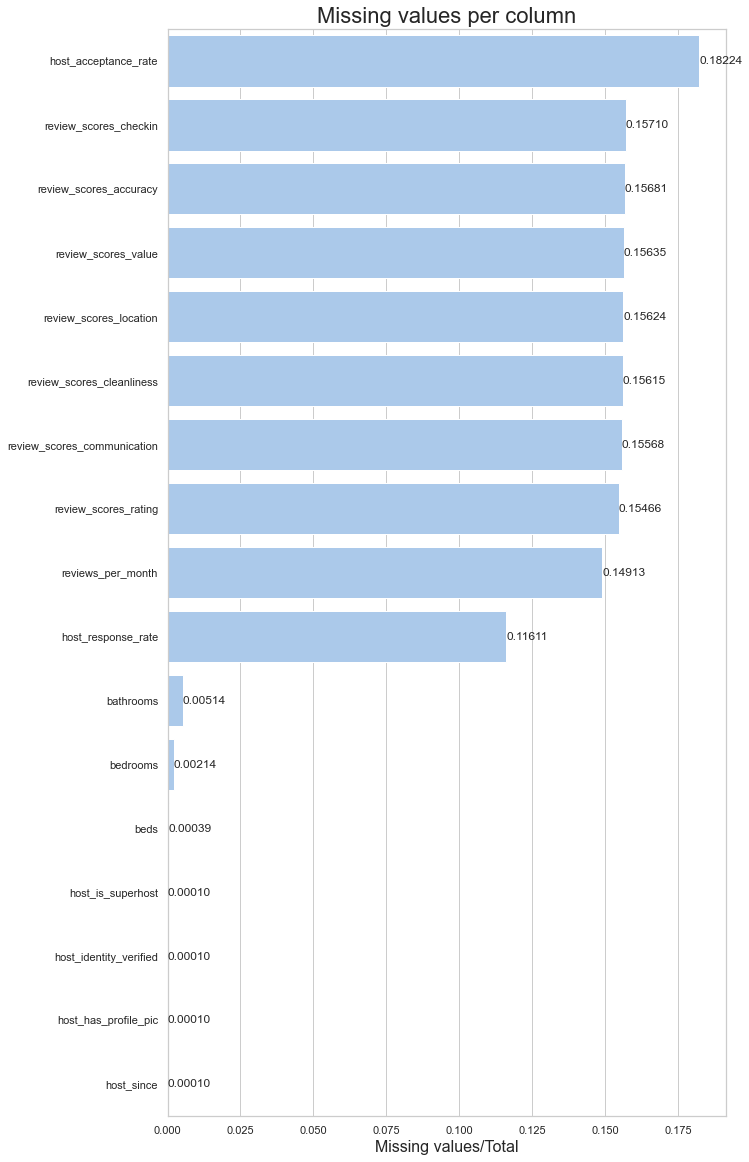

In [335]:
plot_missing_values(df_merged, 'missing_values_per_column_df_merged.png', 10, 20)

Since the columns `beds, bedrooms, bathrooms, property_type, host_identity_verified, 
host_has_profile_pic, host_is_superhost, host_since`
have less than 5% of missing values we will drop these rows. 

In [336]:
drop_columns = ['beds',
                'bedrooms',
                'bathrooms',
                'host_identity_verified',
                'host_has_profile_pic',
                'host_is_superhost',
                'host_since']

df_merged.dropna(subset=drop_columns, inplace = True)

In [337]:
df_merged.shape

(927644, 114)

In [338]:
df_merged[df_merged['available'] == 1].shape

(927644, 114)

In [339]:
df_merged[df_merged['requires_license'] == 0].shape

(927644, 114)

In [340]:
df_merged[df_merged['description'] == 1].shape

(927644, 114)

In [341]:
df_merged[df_merged['picture_url'] == 1].shape

(927644, 114)

In [342]:
df_merged[df_merged['amenities_washer_dryer'] == 0].shape

(927644, 114)

After removing these rows, we noticed that some columns will have no impact in the predictive model, because every row has the same value.
Therefore, we will also drop the following columns:
- 'available'
- 'requires_license'
- 'description'
- 'picture_url'
- 'amenities_washer_dryer'

In [343]:
df_merged.drop(columns=['available',
                        'requires_license',
                        'description',
                        'picture_url',
                        'amenities_washer_dryer'],
              inplace = True)

In [344]:
# end of cleaning
pd.DataFrame(listings_df_cleansed.columns).to_csv('columns.csv')

### Heatmap of Correlation of numeric features

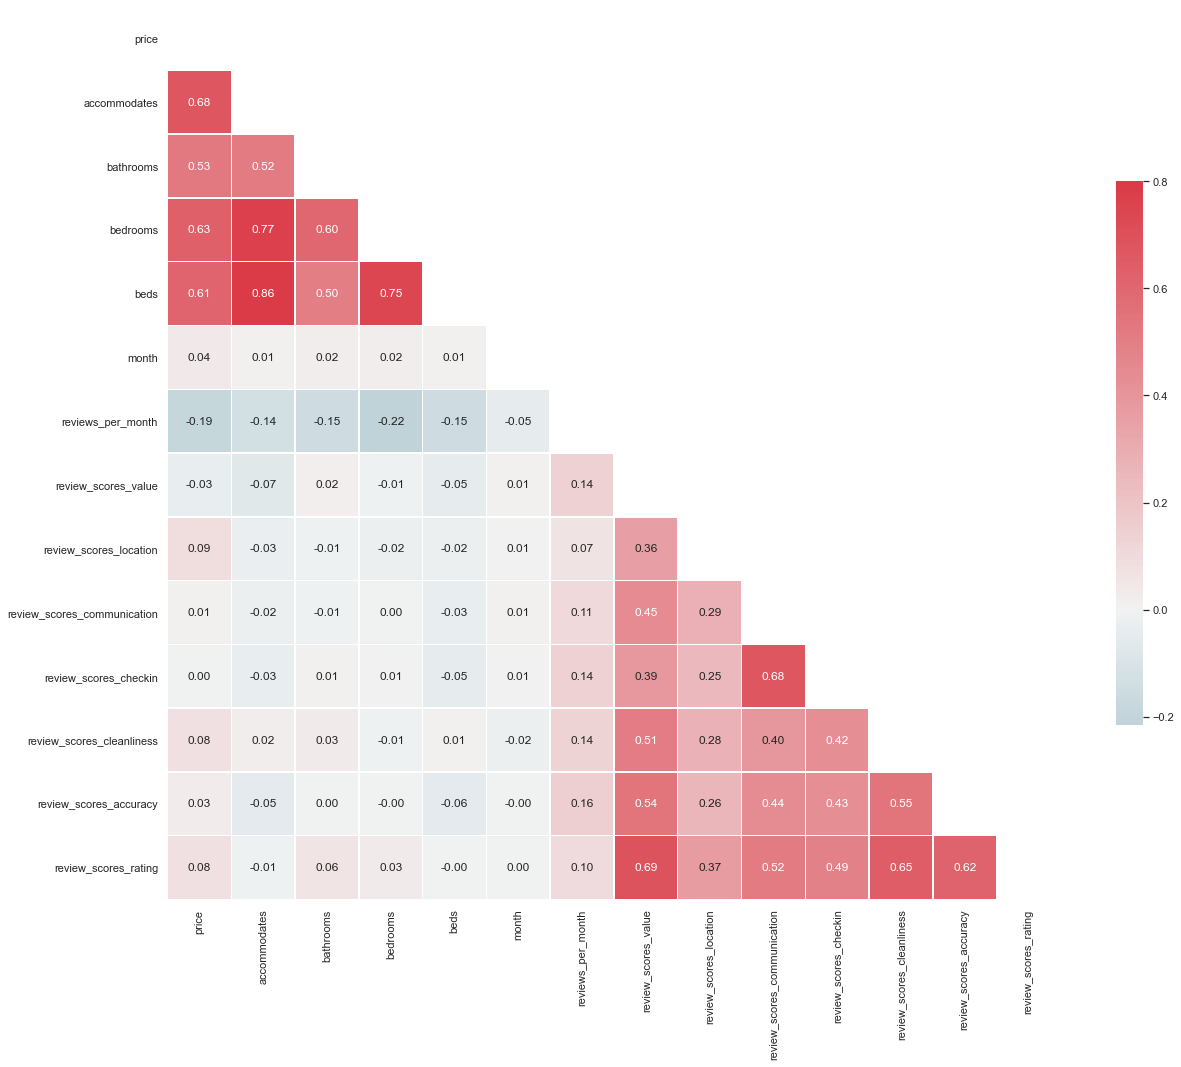

In [345]:
# Compute the correlation matrix of the numeric columns
columns = ['price',
           'accommodates',
           'bathrooms',
           'bedrooms',
           'beds',
           'month',
          'reviews_per_month',
          'review_scores_value',
          'review_scores_location',
          'review_scores_communication',
          'review_scores_checkin',
          'review_scores_cleanliness',
          'review_scores_accuracy',
          'review_scores_rating'
          ]

corr = df_merged[columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
sns.set(style="white")
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set(font_scale=1)
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,fmt = '.2f',
            square=True,annot=True, linewidths=.5, cbar_kws={"shrink": .5})

fig = heatmap.get_figure()
fig.savefig('correlations.png')

---

## Can we see which neighbourhods are most desired in this time of the year?

Now that we have merged the datasets we can see this information.

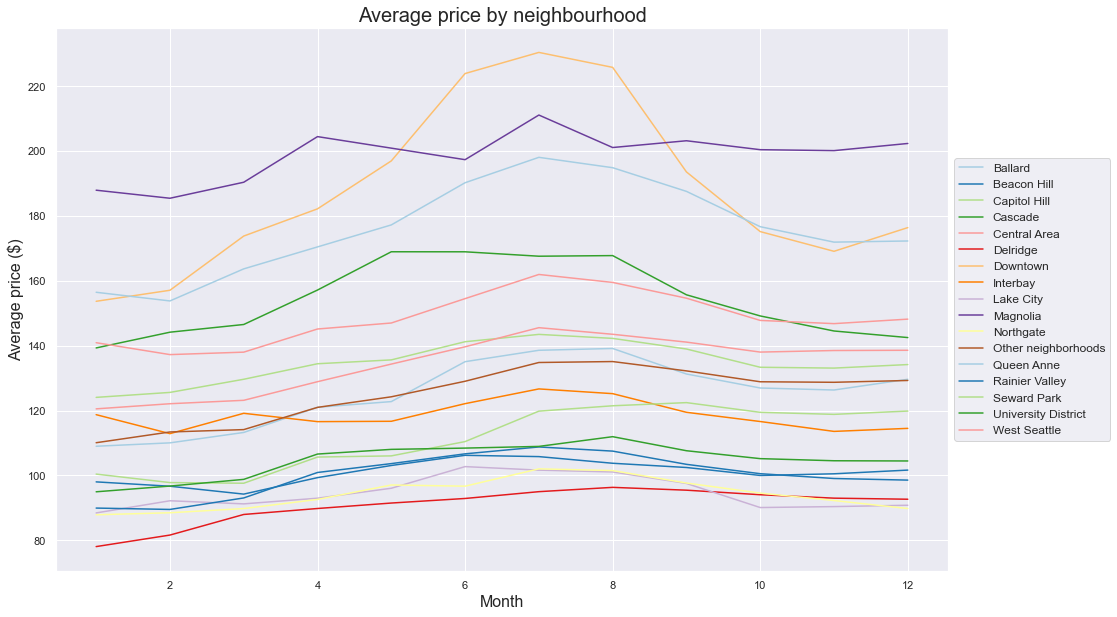

In [346]:
#get list of neighbourhoods
neighbourhoods_list = np.sort(df_merged['neighbourhood_group_cleansed'].unique())

#get prices by month and neighbourhood
price_by_month_neighbourhood = df_merged.groupby(['month','neighbourhood_group_cleansed']).mean().reset_index()

#plot prices for each neighbourhood
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)

colors = sns.color_palette("Paired", len(neighbourhoods_list)*2)

for index, neighbourhood in enumerate(neighbourhoods_list):
    ax.plot(price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['month'],
             price_by_month_neighbourhood[price_by_month_neighbourhood['neighbourhood_group_cleansed'] == neighbourhood]['price'],
             label = neighbourhood, color=colors[index])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.ylabel('Average price ($)', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.title('Average price by neighbourhood', fontsize=20)

sns.set_style("whitegrid")
plt.savefig('average_price_by_neighbourhood.png')

plt.show()

The downtown seems to be the is the most desirable area on the peak time of the year.

---
---

# 4 - Modeling and Predicting

Before spliting ou dataset into train and test, we are going to fill the missing values.

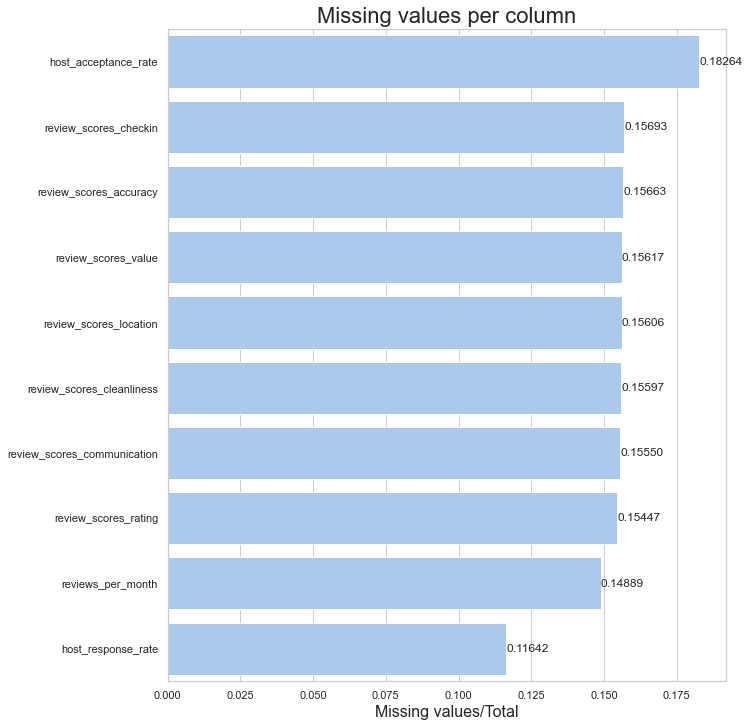

In [347]:
plot_missing_values(df_merged.drop(columns=['price','date', 'host_since', 'neighbourhood_group_cleansed']), 'missing_values_per_column_x.png', 10, 12)

In [348]:
# The other columns missing values, we will fill with the mean()
columns_fill_mean = ['host_acceptance_rate',
                     'review_scores_checkin', 
                     'review_scores_accuracy',
                     'review_scores_value',
                     'review_scores_location',
                     'review_scores_cleanliness',
                     'review_scores_communication',
                     'review_scores_rating',
                     'reviews_per_month',
                     'host_response_rate'
                    ]
fill_mean = lambda col: col.fillna(col.mean())
df_merged[columns_fill_mean] = df_merged[columns_fill_mean].apply(fill_mean, axis=0)

In [349]:
#Split into explanatory and response variables (also dropping some non-numerical variables)
X = df_merged.drop(columns=['price','date', 'host_since', 'neighbourhood_group_cleansed'])
y = df_merged['price'].astype('float')

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
    
print("The r-squared score for the model was {} on {} values.".format(test_score, len(y_test)))
print("The r-squared score for the training was {} on {} values".format(train_score, len(y_train)))

The r-squared score for the model was 0.6231368922568876 on 278294 values.
The r-squared score for the training was 0.61942704870976 on 649350 values


The r-squared value for the training is relatively close to the test score, which means that our model is not overfitting the train dataset.
Altough the r-squared value of 0.62 is far from ideal to predict a price with accuracy yet.

# 5 - Conclusions

## Further Questions
* Most common type of listing change in this time of the year?
* Is there a upward trend for both new Airbnb listings and total Airbnb visitors to Seattle?
* How much % of users make reviews? Is it biased by the time of the year?
* What are the type of accomodations with higherprice?

* Can we get a description of the vibe of each neighbourhood using listing descriptions? (NLP ?)